## Vanilla Policy Gradient

## Create an Environment

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

In [2]:
env = gym.make("LunarLander-v3", continuous=False, render_mode="rgb_array")

# Get number of actions from gym action space
n_actions = int(env.action_space.n)
print(f"Number of possible actions: {n_actions}")
print("""Actions:
0: do nothing
1: fire left orientation engine
2: fire main engine
3: fire right orientation engine
""")

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(f"Number of state observations: {n_observations}")

print("""State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      """)
print("Current state: ", state)

print("""Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      """)

Number of possible actions: 4
Actions:
0: do nothing
1: fire left orientation engine
2: fire main engine
3: fire right orientation engine

Number of state observations: 8
State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      
Current state:  [ 0.00446291  1.4098121   0.45203632 -0.04925022 -0.00516469 -0.10239319
  0.          0.        ]
Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      


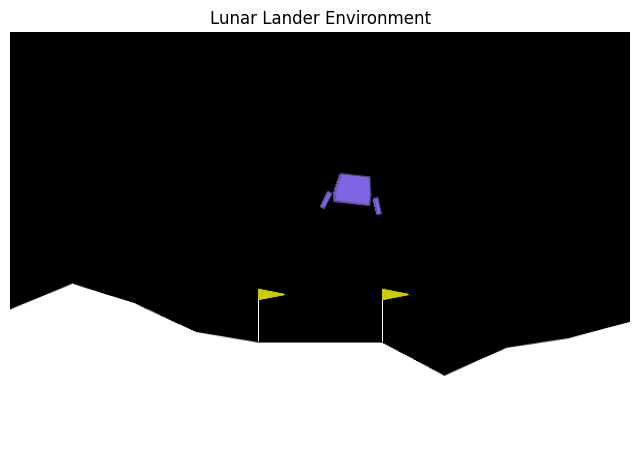

In [3]:
# Reset the environment to get the initial state
state, info = env.reset()

for i in range(50):
    env.step(action=0)
# Render the environment to get an RGB image
frame = env.render()

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(frame)
plt.axis("off")
plt.title("Lunar Lander Environment")
plt.show()

## Create VPG Components

In [4]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam, Optimizer

from typing import Tuple

In [5]:
torch.manual_seed(0)

In [6]:
class MLP(nn.Module):
    def __init__(self, num_inputs: int, num_outputs: int) -> None:
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(num_inputs, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, num_outputs)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [7]:
class VPGPolicy:
    def __init__(
        self,
        num_inputs: int,
        num_outputs: int,
        device: torch.device,
        learning_rate: float = 0.003,
        discount_factor: float = 0.99,
    ) -> None:
        self.device = device

        self.policy_network = MLP(num_inputs, num_outputs)
        self.policy_network.to(self.device)

        self.optimizer = Adam(params=self.policy_network.parameters(), lr=learning_rate)

        self.gamma = discount_factor

    def select_action(self, state: torch.Tensor) -> Tuple[int, torch.Tensor]:
        """
        Selects an action based on the current state and computes its log-probability.

        Args:
            state (torch.Tensor): The current state represented as a tensor.

        Returns:
            Tuple[int, torch.Tensor]:
                - action (int): The chosen action index.
                - log_prob (torch.Tensor): The log-probability of the chosen action.
        """
        # Forward pass through the policy network to get action logits.
        action_logits = self.policy_network(state)

        # Create a categorical distribution from the logits.
        action_distribution = Categorical(logits=action_logits)

        # Sample an action from the distribution.
        sampled_action = action_distribution.sample()

        # Convert the sampled action to a Python integer.
        action_index = int(sampled_action.item())

        # Calculate the log-probability of the selected action.
        log_prob = action_distribution.log_prob(sampled_action)

        return action_index, log_prob

    def compute_discounted_returns(self, rewards: torch.Tensor) -> torch.Tensor:
        """
        Computes discounted returns for a sequence of rewards.

        Args:
            rewards (torch.Tensor): Rewards for the episode.
            gamma (float): Discount factor.

        Returns:
            torch.Tensor: Discounted returns.
        """
        discounted_returns = []
        cumulative_return = 0.0
        for reward in reversed(rewards):
            cumulative_return = reward + self.gamma * cumulative_return
            discounted_returns.insert(0, cumulative_return)
        discounted_returns = torch.tensor(discounted_returns, dtype=torch.float32)
        return (discounted_returns - discounted_returns.mean()) / (discounted_returns.std() + 1e-8)

    def calculate_policy_loss(
        self, episode_log_probability_actions: torch.Tensor, episode_action_rewards: torch.Tensor
    ):
        """
        The loss is negated because most optimization libraries (like PyTorch) perform minimization,
        while the policy gradient aims to maximize the objective J(θ).
        """
        return -(episode_log_probability_actions * episode_action_rewards).mean()

    def optimize_policy(self, episode_log_probability_actions: torch.Tensor, episode_action_rewards: torch.Tensor):
        loss = self.calculate_policy_loss(episode_log_probability_actions, episode_action_rewards)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item()

### Training

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device: ", device)

device = torch.device("cpu")

Using device:  mps


In [9]:
learning_rate = 0.003
discount_factor = 0.99

policy = VPGPolicy(
    num_inputs=n_observations,
    num_outputs=n_actions,
    learning_rate=learning_rate,
    device=device,
    discount_factor=discount_factor,
)

In [10]:
def train_policy_on_batch(env: gym.Env, policy: VPGPolicy, device: torch.device, batch_size: int = 16) -> dict:
    """
    Collects data from multiple episodes and trains the policy on the combined batch.

    Args:
        env: The environment to interact with (following the OpenAI Gym interface).
        policy: The policy object that defines action selection and optimization.
        device: The device to run computations on (CPU/GPU).
        batch_size: Number of episodes to collect before updating the policy.

    Returns:
        dict: A dictionary of metrics tracking batch performance and training progress.
    """
    # Lists to store batch data
    batch_log_probs = []
    batch_rewards = []
    batch_returns = []
    total_rewards = []  # To track episode rewards for logging
    total_steps = 0  # To track steps taken across episodes

    for _ in range(batch_size):
        # Reset the environment for a new episode
        state, _ = env.reset()
        episode_log_probs = []
        episode_rewards = []
        episode_reward = 0.0

        while True:
            # Convert state to tensor and send it to the device
            state_tensor = torch.Tensor(state).to(device)

            # Select an action using the policy
            action, log_prob = policy.select_action(state=state_tensor)

            # Take the selected action in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Store log-probability and reward
            episode_log_probs.append(log_prob)
            episode_rewards.append(reward)

            # Update cumulative reward and state
            episode_reward += reward
            state = next_state
            total_steps += 1

            # Break if the episode ends
            if terminated or truncated:
                break

        # Store episode data into batch data
        total_rewards.append(episode_reward)
        batch_log_probs.extend(episode_log_probs)
        batch_rewards.extend(episode_rewards)

        # Compute discounted returns for the episode and store them
        episode_returns = policy.compute_discounted_returns(torch.Tensor(episode_rewards))
        batch_returns.extend(episode_returns)

    # Convert batch data to tensors
    batch_log_probs_tensor = torch.stack(batch_log_probs).to(device)
    batch_returns_tensor = torch.Tensor(batch_returns).to(device)

    # Optimize the policy
    policy_loss = policy.optimize_policy(batch_log_probs_tensor, batch_returns_tensor)

    # Return metrics to track training progress
    metrics = {
        "batch_reward": sum(total_rewards) / batch_size,  # Average reward per episode
        "total_steps": total_steps,
        "policy_loss": policy_loss,
    }

    return metrics

In [11]:
def train_vpg_policy(
    max_episodes: int = 500, reward_threshold: float = 200.0, rolling_window: int = 100, batch_size: int = 16
):
    rewards_history = []
    loss_history = []
    steps_history = []

    for episode in range(1, max_episodes + 1):
        metrics = train_policy_on_batch(env, policy, device, batch_size)

        # Collect metrics
        rewards_history.append(metrics["batch_reward"])
        loss_history.append(metrics["policy_loss"])
        steps_history.append(metrics["total_steps"])

        # Print metrics every 50 episodes
        if episode % 50 == 0:
            avg_reward = np.mean(rewards_history[-50:])
            print(
                f"Episode {episode}: Average Reward: {avg_reward:.2f}, "
                f"Loss: {metrics['policy_loss']:.4f}, Steps: {metrics['total_steps']}"
            )

        # Convergence condition: Check if the rolling average exceeds the reward threshold
        if len(rewards_history) >= rolling_window:
            avg_rolling_reward = np.mean(rewards_history[-rolling_window:])
            if avg_rolling_reward >= reward_threshold:
                print(
                    f"Environment solved in {episode} episodes! "
                    f"Average reward over the last {rolling_window} episodes: {avg_rolling_reward:.2f}"
                )
                break

    env.close()

    return rewards_history, loss_history, steps_history

In [ ]:
max_episodes = 100
reward_threshold = 200.0
batch_size = 16

rewards_history, loss_history, steps_history = train_vpg_policy(
    max_episodes=max_episodes, reward_threshold=reward_threshold, batch_size=batch_size
)

In [ ]:
# Plot metrics
plt.figure(figsize=(16, 5))

# Plot rewards
plt.subplot(1, 3, 1)
plt.plot(rewards_history, label="Reward per Episode")
plt.axhline(y=reward_threshold, color="r", linestyle="--", label="Reward Threshold")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Rewards")
plt.legend()

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(loss_history, label="Loss per Episode", color="orange")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Policy Loss")
plt.legend()

# Plot steps
plt.subplot(1, 3, 3)
plt.plot(steps_history, label="Steps per Episode", color="green")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Steps Taken")
plt.legend()

plt.tight_layout()
plt.show()

print("Training complete.")